In [1]:
import requests
import collections
import re,random
from datetime import date
import datetime,time
from dateutil.rrule import rrule, DAILY, HOURLY
import pandas as pd
import numpy as np
from utils import *
import langid
import sys,time
import seaborn as sns
import matplotlib.pyplot as plt

#sys.path.append('/usr/local/lib/python2.7/site-packages/')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [15]:
sns.set_context('paper')

In [16]:
import logging
logger=logging.getLogger()
logging.basicConfig(filename='./log.log',level=logging.WARNING)
#logger.setLevel(logging.WARNING)

Check quota [here](https://console.developers.google.com/project/childmarriage-1019/apiui/apiview/youtube/quotas)

In [85]:
taxonomyWords=['child marriage','child bride','underage bride','teen bride','forced marriage','early marriage']
taxonomyWords.extend([u'बाल विवाह',u'बालिका वधु',u'नाबालिक विवाह',u'नाबालिक वधु',u'किशोर वधु',u'किशोर बीवी',u'जबरन शादी',u'जबरन विवाह'])
taxonomyWords=map(lambda x:'"'+x+'"',taxonomyWords)
#taxonomyWords=map(lambda x:'%22'+x+'%22',taxonomyWords)
#FULLQUERY='|'.join(taxonomyWords)
FULLQUERY='%7C'.join(taxonomyWords)


In [18]:
FULLQUERY

'%22child marriage%22%7C%22child bride%22%7C%22underage bride%22%7C%22teen bride%22%7C%22forced marriage%22%7C%22early marriage%22'

In [19]:
QUERY=re.escape('"child marriage"|"child bride"')
from secrets import KEY

diff=1

In [20]:
def getVideoParts(vData):
    title=res['items'][0]['snippet'].get('title')
    time=res['items'][0]['snippet'].get('publishedAt')
    tags=res['items'][0]['snippet'].get('tags')
    lang=res['items'][0]['snippet'].get('defaultAudioLanguage')
    description=res['items'][0]['snippet'].get('description')
    commentCount=viewCount=favouriteCount=dislikeCount=likeCount=None
    
    stats=res['items'][0].get('statistics')

    commentCount=stats.get('commentCount')
    viewCount=stats.get('viewCount')
    favouriteCount=stats.get('favoriteCount')
    dislikeCount=stats.get('dislikeCount')
    likeCount=stats.get('likeCount')
    
    return time,title,tags,lang,description,commentCount,viewCount,favouriteCount,dislikeCount,likeCount

In [21]:
def getCountryFromInfo(info):
    if len(info['items'])>0:
        return info['items'][0]['snippet'].get('country')
    else:
        return None

In [22]:
def getDescriptionFromInfo(info):
    if len(info['items'])>0:
        return info['items'][0]['snippet'].get('description')
    else:
        return None

In [23]:
def getTitleFromInfo(info):
    if len(info['items'])>0:
        return info['items'][0]['snippet'].get('title')
    else:
        return None

In [24]:
def getVideoInfoFromVideo(vid):

        requestString='https://www.googleapis.com/youtube/v3/videos?part=snippet,statistics&id='+vid+'&key='+KEY

        logging.info('QUERYING VIDEO %s' % vid)

        d=requests.get(requestString)

        data=d.json()
        
        if not data.get('items') or not d.status_code==200:
            logging.warning('Error getting video info %s' % vid)
            logging.warning(data)
            return None
        
        return data

In [25]:
def getChannelInfoFromChannel(cid):
    requestString='https://www.googleapis.com/youtube/v3/channels?part=snippet&id='+cid+'&key='+KEY

    logging.info('QUERYING CHANNEL'+cid)

    d=requests.get(requestString)

    return d.json()

In [68]:
def getRepliesFromComment(commentId,commentTime,commentText,nextReplyPageToken):
    
    if not nextReplyPageToken:
        requestString='https://www.googleapis.com/youtube/v3/comments?part=snippet&maxResults=100&parentId='+commentId+\
    '&key='+KEY
    else:
        logging.warning('Requesting reply page %s' % nextReplyPageToken)
        requestString='https://www.googleapis.com/youtube/v3/comments?part=snippet&maxResults=100&parentId='+commentId+\
    '&pageToken='+nextReplyPageToken+'&key='+KEY
    
    isMore=False
    
    d=requests.get(requestString)
    
    returnData=d.json()
    
    newNextToken=returnData.get('nextPageToken')
    newPreviousToken=returnData.get('prevPageToken')
    logging.warning('Tokens Next: %s Previous: %s' % (newNextToken,newPreviousToken))
    
    if newNextToken:
        if len(newNextToken)>0:
            logging.warning('!!!!More than 100 replies....')
            isMore=True
    
    return returnData,isMore,newNextToken
# commentData['items'],isMoreComments,nextToken

In [69]:
def getVideos(end,start,nextToken):
    '''
    Note that data['pageInfo']['totalResults'] is not reliable
    '''
    if not nextToken:
        requestString='https://www.googleapis.com/youtube/v3/search?part=snippet&q='\
        +FULLQUERY+'&key='+KEY+'&maxResults=50&type=video&publishedBefore='+end+'&publishedAfter='+start
    else:
        requestString='https://www.googleapis.com/youtube/v3/search?part=snippet&q='\
        +FULLQUERY+'&key='+KEY+'&maxResults=50&type=video&publishedBefore='+end+'&publishedAfter='+start\
        +'&pageToken='+nextToken
        logging.warning('Next page token: %s' % nextToken)
    '''
    print requestString
    print re.escape(requestString)
    sys.exit(1)
    '''
        
    print 'QUERYING API IN RANGE',start,end
    logging.info('QUERYING API IN RANGE %s - %s' % (start,end))
        
    d=requests.get(requestString)
    
    if not d.status_code==200:
        logging.warning('Search return code %d' % d.status_code)
        logging.warning(d.json())
        logging.warning(requestString)

    data=d.json()
        
    newNextToken=data.get('nextPageToken')
    newPreviousToken=data.get('prevPageToken')
    logging.warning('Tokens Next: %s Previous: %s' % (newNextToken,newPreviousToken))

    isMore=False
    
    if newNextToken:
        if len(newNextToken)>0 and not (newNextToken==nextToken):
            logging.warning('!!!!More than 50 videos....')
            isMore=True
            
    return data,isMore,newNextToken

In [70]:
def getCommentsFromVideo(vid,nextCommentPageToken):
#   data,isMoreComments,nextPageToken=getCommentsFromVideo(videoId,nextCommentPageToken)

    if not nextCommentPageToken:
        requestString='https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&maxResults=100&'\
        'videoId='+vid+'&key='+KEY
    else:
        requestString='https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&maxResults=100'\
        +'&pageToken='+nextCommentPageToken+'&videoId='+vid+'&key='+KEY
    
        
    res=requests.get(requestString)
    commentData=res.json()

    if res.status_code==403:
        # Comments disabled
        logging.warning('Comments error %d,%s' % (res.status_code,vid))
#        logging.warning(commentData)
        return [],False,None
    
    nAttempts=0
    
    while not res.status_code==200:
        logging.warning('Error %d' % res.status_code)
#        logging.warning('%s' %commentData)
        print commentData
        print requestString
        print vid,nextCommentPageToken,KEY
        loggin.warning('Sleeping (attempt #%d)' % nAttempts)
        time.sleep(60)
        res=requests.get(requestString)
        commentData=res.json()
        nAttempts+=1
        if nttempts==10:
            logging.warning('Giving up')
            return [],False,None
        
    isMoreComments=False
    
    nextToken=commentData.get('nextPageToken')
    
    if nextToken:
        if len(nextToken)>0:
            logging.warning('More than 100 comments for video %s' % vid)
            isMoreComments=True
    
    try:
        logging.info('Got %d comments' % (len(commentData['items'])))
    except:
        logging.warning('!!!!ERROR',commentData.keys())
        logging.warning('%d' % res.status_code)
#        logging.warning(commentData)
    
    return commentData['items'],isMoreComments,nextToken

In [111]:
nDayDiff=2
# Look back n days from start date

diff=4
# Start date is yesterday

now=datetime.datetime.now()

endDate=date(now.year,now.month,now.day)
# Throw away hour, minute, second

endDate=endDate-datetime.timedelta(days=diff)
endDateTemp=endDate
# Look back diff days

startDate=endDate-datetime.timedelta(days=nDayDiff)
startDateTemp=startDate

endDate=endDate.strftime("%Y-%m-%dT%H:%M:%SZ")
startDate=startDate.strftime("%Y-%m-%dT%H:%M:%SZ")

startDates=[startDate]
endDates=[endDate]

logging.info('%s - %s' %  (' '.join(startDates),' '.join(endDates)))

startDates=[d for d in rrule(DAILY,dtstart=startDateTemp,until=endDateTemp-datetime.timedelta(days=1))]
startDates=[d.strftime("%Y-%m-%dT%H:%M:%SZ") for d in startDates]

logging.info('Start dates %s' % (' '.join(startDates)))

vIdList=[]
vTimeList=[]
vTitleList=[]
vLangList=[]
vTagList=[]
vDescriptionList=[]
vCommentCountList=[]
vViewCountList=[]
vFavouriteCountList=[]
vDislikeCountList=[]
vLikeCountList=[]
vDescriptionLangList=[]
vTitleLangList=[]
# Initialise video lists

cIdList=[]
cCountryList=[]
cDescriptionList=[]
cTitleList=[]
# Initialise channel lists

commentIdList=[]
commentVideoIdList=[]
commentTextList=[]
commentUserIdList=[]
commentLikesList=[]
commentTimeList=[]
commentTextLangList=[]
# Initialise comment lists

replyTextList=[]
replyCommentIdList=[]
replyTimeList=[]
replyAuthorIdList=[]
replyLikeCountList=[]
replyVideoIdList=[]
replyLangList=[]
# Initialise reply lists

##############
for start,end in zip(startDates[0:-1],startDates[1:]):

    isMoreVideos=True
    nextPageToken=None
    
    while isMoreVideos:
        logging.warning('Getting more videos')
        data,isMoreVideos,nextPageToken=getVideos(end,start,nextPageToken)

        logging.warning('Data keys %s' % data.keys())
        logging.warning('Got %d videos' % (len(data['items'])))
        logging.warning('Got %d unique videos' % (len([vv[u'id']['videoId'] for vv in data['items'] if not vv[u'id']['videoId'] in vIdList])))

        videoIds=[]

        for v,video in enumerate(data['items']):
            ############################################
            # Video stuff

            videoId=video[u'id']['videoId']
            if not videoId in vIdList:
                # Some duplicate videos are returned
                vIdList.append(videoId)

                videoIds.append(videoId)
                videoData=getVideoData(videoId)
                
                if videoData.get('missing'):
                    logging.warning('Video Missing %s' % videoId)

                logging.info('Video ID %s' % videoId)
#                logging.info('Video keys %s' % (videoData['items'][0].keys()))

                res=getVideoInfoFromVideo(videoId)
        
                if res:
                # If video could be retrieved
                    channelId=res['items'][0]['snippet']['channelId']

                    vTime,vTitle,vTags,vLang,vDescription,vCommentCount,vViewCount,vFavouriteCount,vDislikeCount,vLikeCount=\
                    getVideoParts(res['items'][0])

                    logging.info('Video Title: %s' % vTitle)
                    vTitleList.append(vTitle)

                    logging.info('Video time: %s' % vTime)
                    vTimeList.append(vTime)

                    logging.info('Video tags: %s' % vTags)
                    vTagList.append(vTags)

                    if vLang:logging.info('Video lang: %s' % vLang)
                    vLangList.append(vLang)

                    if False:print 'Video Description:',vDescription
                    vDescriptionList.append(vDescription)

                    vTitleLang=langid.classify(vTitle)[0]
                    vDescriptionLang=langid.classify(vDescription)[0]

                    logging.info('Video Stats %s' % ' '.join([k+':'+v for k,v in zip(['comments','views','favs','dislike','like'],[vCommentCount,vViewCount,vFavouriteCount,vDislikeCount,vLikeCount]) if v]))
                    vCommentCountList.append(vCommentCount)
                    vViewCountList.append(vViewCount)
                    vFavouriteCountList.append(vFavouriteCount)
                    vDislikeCountList.append(vDislikeCount)
                    vLikeCountList.append(vLikeCount)
                    vDescriptionLangList.append(vDescriptionLang)
                    vTitleLangList.append(vTitleLang)
                    
                    isMoreComments=True
                    nextCommentPageToken=None
    
                    while isMoreComments:
                        if nextCommentPageToken:
                            logging.warning('Getting more comments')
                            logging.warning('%s',nextCommentPageToken)
                        else:
                            logging.warning('Getting first comments for %s' % videoId)
                        commentThreads,isMoreComments,nextCommentPageToken=getCommentsFromVideo(videoId,nextCommentPageToken)

#                    commentThreads,isMoreComments=getCommentsFromVideo(videoId)

                        for thread in commentThreads:

                            commentId=thread['snippet']['topLevelComment']['id']
                            commentIdList.append(commentId)

                            commentVideoId=thread['snippet']['topLevelComment']['snippet']['videoId']
                            commentVideoIdList.append(commentVideoId)

                            commentText=thread['snippet']['topLevelComment']['snippet']['textDisplay']
                            commentTextList.append(commentText)
                            commentTextLang=langid.classify(commentText)[0]
                            commentTextLangList.append(commentTextLang)

                            commentTime=thread['snippet']['topLevelComment']['snippet']['publishedAt']
                            commentTimeList.append(commentTime)

                            try:commentUser=thread['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
                            except:commentuser=None

                            commentUserIdList.append(commentUser)

                            commentLikes=thread['snippet']['topLevelComment']['snippet']['likeCount']
                            commentLikesList.append(commentLikes)

                            if thread['snippet']['totalReplyCount']>0:
                                
                                isMoreReplies=True
                                nextReplyPageToken=None
                                while isMoreReplies:
                                    replies,isMoreReplies,nextReplyPageToken=getRepliesFromComment(commentId,commentTime,commentText,nextReplyPageToken)
                                    logging.info('%d replies' % (len(replies)))

                                    for reply in replies['items']:
                                        replyVideoIdList.append(videoId)
                                        replyText=reply['snippet']['textDisplay']
                                        replyTextList.append(replyText)
                                        replyTextLang=langid.classify(replyText)[0]
                                        replyLangList.append(replyText)

                                        replyCommentId=reply['snippet']['parentId']
                                        replyCommentIdList.append(replyCommentId)

                                        replyTime=reply['snippet']['publishedAt']
                                        replyTimeList.append(replyTime)

                                        try:replyAuthorId=reply['snippet']['authorChannelId']['value']
                                        except:
                                            logging.warning('Reply no author id %s' % reply['snippet'])
                                            replyAuthorId=None
                                        replyAuthorIdList.append(replyAuthorId)

                                        replyLikeCount=reply['snippet']['likeCount']
                                        replyLikeCountList.append(replyLikeCount)
                    logging.warning('Got all comments for video')
                    ############################################
                    # Channel stuff

                    info=getChannelInfoFromChannel(channelId)
                    cIdList.append(channelId)

                    cCountry=getCountryFromInfo(info)
                    logging.info('Channel Country: %s' % cCountry)
                    cCountryList.append(cCountry)

                    cDescription=getDescriptionFromInfo(info)
                    if False:print 'Channel Description:',cDescription
                    cDescriptionList.append(cDescription)

                    cTitle=getTitleFromInfo(info)
                    logging.info('Channel Title %s' % cTitle)
                    cTitleList.append(cTitle)
                else:
                    vTitleList.append(None)
                    vTimeList.append(None)
                    vTagList.append(None)
                    vLangList.append(None)
                    vDescriptionList.append(None)
                    vCommentCountList.append(None)
                    vViewCountList.append(None)
                    vFavouriteCountList.append(None)
                    vDislikeCountList.append(None)
                    vLikeCountList.append(None)
                    vTitleLangList.append(None)
                    
                    vTitleLangList.append(None)
                    vDescriptionList.append(None)
                    vDescriptionLangList.append(None)
                    
                    cIdList.append(None)
                    cCountryList.append(None)
                    cDescriptionList.append(None)
                    cTitleList.append(None)
                logging.info('\n')

                assert len(vIdList)==len(vTitleList)==len(vTagList)==len(vLangList)==len(vDescriptionList)==len(vViewCountList)\
                ==len(vFavouriteCountList)==len(vDislikeCountList)==len(vLikeCountList)==len(vTimeList)==len(vTitleLangList)\
                ==len(cIdList)==len(cCountryList)==len(cDescriptionList)==len(cTitleList)==len(vTimeList)==len(vDescriptionLangList)\
                ,'Video data mismatched'

                assert len(commentIdList)==len(commentLikesList)==len(commentTextList)==len(commentTimeList)\
                ==len(commentUserIdList)==len(commentVideoIdList)\
                ,'Comment data mismatched'

                assert len(replyAuthorIdList)==len(replyCommentIdList)==len(replyLikeCountList)==len(replyTextList)\
                ==len(replyTimeList)\
                ,'Reply data mismatched'

        logging.warning('Stats: %d videos %d comments %d replies' %(len(vIdList),len(commentIdList),len(replyCommentIdList)))
    
    logging.warning('End of pagination\n')
logging.warning('Finished looping over dates\n')
    
videoDf=pd.DataFrame(data={'id':vIdList,'title':vTitleList,'tags':vTagList,'lang':vLangList,'description':vDescriptionList,\
                'descriptionLang':vDescriptionLangList,'views':vViewCountList,'favourites':vFavouriteCountList,'dislikes':vDislikeCountList,\
                'titleLang':vTitleLangList,'likes':vLikeCountList,'channelId':cIdList,'channelCountry':cCountryList,\
                'channelDescription':cDescriptionList,'channelTitle':cTitleList},index=vTimeList)       
      
commentDf=pd.DataFrame(data={'text':commentTextList,'videoId':commentVideoIdList,'id':commentIdList,\
                             'likes':commentLikesList,'user':commentUserIdList,'lang':commentTextLangList},index=commentTimeList)

replyDf=pd.DataFrame(data={'text':replyTextList,'likes':replyLikeCountList,'author':replyAuthorIdList,'lang':replyLangList,\
                           'parentComment':replyCommentIdList,'parentVideo':replyVideoIdList},index=replyTimeList)

QUERYING API IN RANGE 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z
QUERYING API IN RANGE

 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z
QUERYING API IN RANGE

 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z
QUERYING API IN RANGE

 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z
QUERYING API IN RANGE

 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z
QUERYING API IN RANGE

 2015-08-04T00:00:00Z 2015-08-05T00:00:00Z


In [115]:
replyDf.columns

Index([u'author', u'likes', u'parentComment', u'parentVideo', u'text'], dtype='object')

In [ ]:
trash1,trash2,trash3=getVideos(end,start,None)

In [116]:
print replyDf.shape,videoDf.shape,commentDf.shape

(29541, 5) (7233, 13) (30736, 5)


###Set indices to datetime

In [77]:
videoDf.index=pd.to_datetime(videoDf.index)
commentDf.index=pd.to_datetime(commentDf.index)
replyDf.index=pd.to_datetime(replyDf.index)

In [79]:
replyDf.parentVideo.value_counts()

rOdCTh4C7ek    1155
MFaO69kWzDg     212
TI6Eb2IZPhk     121
M5mQFDdO4V8     113
CfgzEWXNf7w      62
fjGUKV-0FL0      42
i92m46GjvAE      33
muxlP4HLWsg      32
zJ-PdHN1h8U      21
WNJIhypoUDY      21
5Nf-uc12L0A       7
w_fhQZ0h33I       6
nJeBXJ10uO8       3
MaXZzyKr-3o       2
WvldmLnF7xc       1
k7N4P61a0z4       1
Te1V6Z9J_pk       1
BNTVmZhZDd8       1
SVljYR-tdxw       1
dtype: int64

###Write Out

In [35]:
videoDf.to_pickle('videos.dat')
commentDf.to_pickle('comments.dat')
replyDf.to_pickle('replies.dat')

###Read In

In [112]:
videoDf=pd.read_pickle('videos.dat')
commentDf=pd.read_pickle('comments.dat')
replyDf=pd.read_pickle('replies.dat')

In [95]:
def matchesIndia(x,term=None):
    if x:
        if term:
            if term in x:
                return True    
        else:
            if 'India' in x:
                return True
    return False

In [96]:
sum(videoDf.tags.apply(matchesIndia).values)

92

In [97]:
collections.Counter(videoDf[~pd.isnull(videoDf.channelCountry)].channelCountry.values).most_common()[0:10]

[(u'IN', 178),
 (u'US', 119),
 (u'UG', 40),
 (u'GB', 25),
 (u'RU', 10),
 (u'NP', 10),
 (u'CA', 6),
 (u'VN', 6),
 (u'KZ', 6),
 (u'BD', 4)]

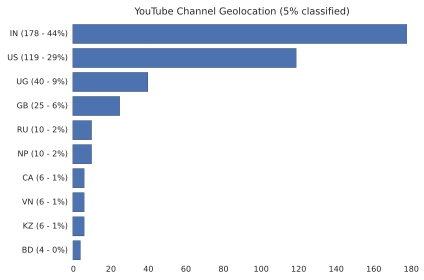

In [98]:
vals=collections.Counter(videoDf[~pd.isnull(videoDf.channelCountry)].channelCountry.values).most_common()[0:10]
# Throw out null
vals.reverse()
plt.barh([i for i in range(10)],[v[1] for v in vals],0.8)
plt.yticks([i+0.4 for i in range(10)],[v[0]+' (%d - %d%%)' % (v[1],int((100*v[1])/sum([v[1] for v in vals]))) for v in vals])
plt.title('YouTube Channel Geolocation (%d%% classified)' % (100*sum([v[1] for v in vals])/(videoDf.shape[0])))
plt.tight_layout()
plt.savefig('../charts/youtube_country_dist.png',dpi=300)

In [ ]:
vals=collections.Counter(videoDf[~pd.isnull(videoDf.channelCountry)].channelCountry.values).most_common()[0:10]
# Throw out null
vals.reverse()
plt.barh([i for i in range(10)],[v[1] for v in vals],0.8)
plt.yticks([i+0.4 for i in range(10)],[v[0]+' (%d - %d%%)' % (v[1],int((100*v[1])/sum([v[1] for v in vals]))) for v in vals])
plt.title('YouTube Channel Geolocation (%d%% classified)' % (100*sum([v[1] for v in vals])/(videoDf.shape[0])))
plt.tight_layout()
plt.savefig('../charts/youtube_country_dist.png',dpi=300)

In [186]:
videoDf[videoDf.channelCountry=='VN'].icol([3,4,10,11])

,channelTitle,description,tags,title
2015-08-01T18:43:11.000Z,Thế Giới Bình An 01,"Địa Chỉ Cô Đồng Sinh “ Thôn ngọc cục, xã thúc ...","[Gọi hồn cô đồng sinh, goi hon co dong sinh, c...",Gọi Hồn Cô Đồng Sinh vong 04 Chiều Ngày 31/0...


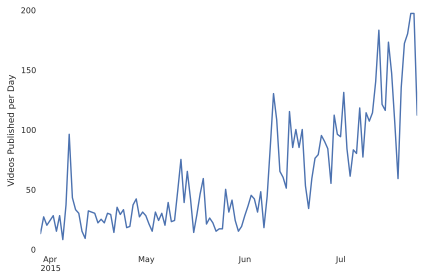

In [113]:
#chosenCountry='ET'
chosenCountry=None

if chosenCountry:
    videoDf[videoDf.channelCountry==chosenCountry]['id'].resample('d',how='count').plot()
else:
    videoDf['id'].resample('d',how='count').plot()
if chosenCountry:
    plt.ylabel('Videos Published per Day (%s)' % chosenCountry)
else:
    plt.ylabel('Videos Published per Day')
plt.tight_layout()

if chosenCountry:
    plt.savefig('../charts/youtube_time_%s.png' % chosenCountry,dpi=300)
else:
    plt.savefig('../charts/youtube_time.png',dpi=300)

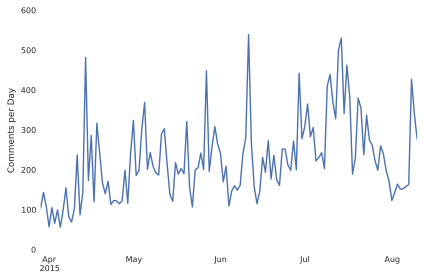

In [100]:
commentDf[commentDf.index>pd.datetime(2015,1,1)]['id'].resample('d',how='count').plot()
plt.ylabel('Comments per Day')
plt.tight_layout()
plt.savefig('../charts/youtube_comments_time.png',dpi=300)

In [139]:
commentDf.videoId.value_counts()[0:10]

yl-ir_BZeNs    1
tYfx1yJmuWw    1
XPR7NburrlY    1
dtype: int64

In [205]:
oldIds=videoDf.id.values

In [211]:
for r in random.sample(videoDf[~(videoDf.channelCountry=='IN')].id.values,10):
    print r,videoDf[videoDf.id==r].title.values[0]#,videoDf[videoDf.id==r].title.values[0],videoDf[videoDf.id==r].description.values[0]
    print '=================='

Av3b2BZd_Sc Balika Vadhu - 7rd August 2015 - बालिका वधु - Full Episode (HD)
DbN_EPFTAP4 House, bridge washed away in heavy rains in Manipur (02-08-2015)
cV6QUlQPTRQ Green Porno review
J5vSI0VipZs Balika Vadhu - 7th August 2015 - बालिका वधु - Full Episode (HD)
kpIM48wbc6w Balika Vadhu - 7th August 2015 - बालिका वधु - Full Episode (HD)
ydy-GzzCbdg Balika Vadhu - 07th August 2015 - बालिका वधु - Full Episode (
rHuQAczLi4I Balika Vadhu - 7th August 2015 - बालिका वधु - Full Episode (HD)
44MqfElwNJA Balika Vadhu - 06th August 2015 - बालिका वधु - Full Episode (HD)
G6bWYXCjY74 Dolla Morte review
fgOx9PybAxs Balika Vadhu - 7th August 2015 - बालिका वधु - Full Episode (HD)


In [202]:
FULLQUERY

'"child marriage"|"child bride"|"underage bride"|"teen bride"|"forced marriage"|"early marriage"'